# Masterarbeit (Batch-Tool)

In [1]:
# Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

#Use notebook for interactive plots
#%matplotlib notebook
%matplotlib inline

In [2]:
# JSON Lib
! pip install demjson
import demjson

In [3]:
# Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [5]:
# Show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Dateien ausgeben und Variablen setzen
dir_var = "../"
! ls -al ../

total 32
drwxr-xr-x 10 jovyan users   320 Dec 11 14:25 .
drwsrwsr-x  1 jovyan users  4096 Dec 12 15:11 ..
drwxr-xr-x 33 jovyan users  1056 Dec 11 14:25 DS-08-10-2020
drwxr-xr-x 18 jovyan users   576 Dec 11 14:25 DS-22-10-2020
drwxr-xr-x 14 jovyan users   448 Dec 12 15:20 .git
-rw-r--r--  1 jovyan users    43 Dec 11 14:25 .gitattributes
-rw-r--r--  1 jovyan users    30 Dec 11 14:25 .gitignore
-rw-r--r--  1 jovyan users 11357 Dec 11 14:25 LICENSE
drwxr-xr-x  5 jovyan users   160 Dec 12 15:47 notebooks
-rw-r--r--  1 jovyan users   102 Dec 11 14:25 README.md


## Process jobs

In [7]:
dfInputFiles = pd.read_excel(dir_var + "notebooks/inputFiles.xlsx", header=None, names=["inputName", "inputPath", "inputType", "inputId"])

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [8]:
# Take only samples
dfInputFiles = dfInputFiles.tail(45)
dfInputFiles = dfInputFiles.head(5)
#dfInputFiles = dfInputFiles[dfInputFiles.inputName.str.contains("FREIHEIT")]

### Overview jobs

In [9]:
dfInputFiles

,inputName,inputPath,inputType,inputId
2,ATTILA HILDMANN OFFICIAL ⚫️⚪️🔴⚔️,DS-08-10-2020/ChatExport_2020-09-25-hildmann,public_channel,10034163583
3,Gerechtigkeit für das Vaterland,DS-08-10-2020/ChatExport_2020-09-26-gerechtigk...,public_channel,10069007089
4,Corona Virus Informationen,DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo,public_channel,9917074801
5,Liberté,DS-08-10-2020/ChatExport_2020-09-26-liberte,public_channel,10068807626
6,ॐ Golden Age Network ॐ,DS-08-10-2020/ChatExport_2020-09-26-goldenage,public_channel,9862302472


### Transform jobs

In [10]:
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + filePath + "/result.json", encoding='utf-8')
    return dF

In [11]:
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [12]:
def checkIsFormattedText(text):
    textString = str(text)
    if(textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    else:
        return False

In [13]:
def convertToValidText(processedIsFormattedText, text):
    
    if(processedIsFormattedText != True):
        #Is no JSON
        return text;
    else:
        #Is json try to parse
        try:
            jsonList = demjson.decode(str(text), encoding='utf8')

            returnList = []

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isFormatted = messageString.startswith("{") and messageString.endswith("}")

                if(isFormatted):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "text_link"):
                        #text and href included (only return text)
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included (only return text)
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included (dont return)
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included (dont return)
                        returnList = returnList
                        
                    else:
                        print("- Error: Unknown type " + subJsonType)
                        returnList = returnList

                else:
                    # Is Normal Sub String
                    returnList.append(messageString)

            return ''.join(returnList)
        
        except:
            #Parser error
            print("- Warn: Json parser error (set return text to inputText) >>" + text + "<<")
            return text

In [14]:
# Timer Start
timeStartGlobal = time.time()

# Add Key = filePath / Value = DataFrame (Metadata)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Messages)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    timeStartSingle = time.time()
    print("[Process now " + fP + "]")
    dfMessages = convertToDataFrameMessages(fP, dictMeta)
    
    dfMessages["processedChannelFilePath"]  = fP
    dfMessages["processedChannelType"]      = dictMeta[fP].type.iloc[0]
    dfMessages["processedRawTextSize"]      = dfMessages["text"].str.len()
    dfMessages["processedIsFormattedText"]  = dfMessages["text"].apply(checkIsFormattedText)
    dfMessages["processedValidText"]        = dfMessages.apply(lambda x: convertToValidText(x.processedIsFormattedText, x.text), axis=1)
    dfMessages["processedValidTextSize"]    = dfMessages["processedValidText"].str.len()
    
    dictMessages[fP] = dfMessages
    timeEndSingle = time.time()
    print('{:5.3f}s'.format(timeEndSingle-timeStartSingle))

# All Messages to DataFrame
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    
    print("[Append now " + fP + "]")
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)

# Print Time
timeEndGlobal = time.time()
print()
print("[Finished global]")
print('{:5.3f}s'.format(timeEndGlobal-timeStartGlobal))

[Process now DS-08-10-2020/ChatExport_2020-09-25-hildmann]
23.912s
[Process now DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland]
1.139s
[Process now DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo]
10.469s
[Process now DS-08-10-2020/ChatExport_2020-09-26-liberte]
3.922s
[Process now DS-08-10-2020/ChatExport_2020-09-26-goldenage]
5.200s
[Append now DS-08-10-2020/ChatExport_2020-09-25-hildmann]
[Append now DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland]
[Append now DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo]
[Append now DS-08-10-2020/ChatExport_2020-09-26-liberte]
[Append now DS-08-10-2020/ChatExport_2020-09-26-goldenage]

[Finished global]
45.243s


### Type of channels

In [15]:
dfInputFiles.inputType.value_counts()

public_channel    5
Name: inputType, dtype: int64

### Only in different types of channels

In [16]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_channel"].dropna(how='all', axis=1).columns
)

Index([], dtype='object')

In [17]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_supergroup"].dropna(how='all', axis=1).columns
)

Index(['action', 'author', 'date', 'duration_seconds', 'edited', 'file',
       'forwarded_from', 'height', 'id', 'live_location_period_seconds',
       'location_information.latitude', 'location_information.longitude',
       'media_type', 'message_id', 'mime_type', 'performer', 'photo',
       'poll.answers', 'poll.closed', 'poll.question', 'poll.total_voters',
       'processedChannelFilePath', 'processedChannelType',
       'processedIsFormattedText', 'processedRawTextSize',
       'processedValidText', 'processedValidTextSize', 'reply_to_message_id',
       'sticker_emoji', 'text', 'thumbnail', 'title', 'type', 'via_bot',
       'width'],
      dtype='object')

In [18]:
# Vorsicht: Wenige Daten
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "private_supergroup"].dropna(how='all', axis=1).columns
)

Index(['action', 'author', 'date', 'duration_seconds', 'edited', 'file',
       'forwarded_from', 'height', 'id', 'live_location_period_seconds',
       'location_information.latitude', 'location_information.longitude',
       'media_type', 'message_id', 'mime_type', 'performer', 'photo',
       'poll.answers', 'poll.closed', 'poll.question', 'poll.total_voters',
       'processedChannelFilePath', 'processedChannelType',
       'processedIsFormattedText', 'processedRawTextSize',
       'processedValidText', 'processedValidTextSize', 'reply_to_message_id',
       'sticker_emoji', 'text', 'thumbnail', 'title', 'type', 'via_bot',
       'width'],
      dtype='object')

## Queries

In [19]:
def queryChannelId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [20]:
def queryChannelName(filePath):
    dfMeta = dictMeta[filePath].copy()
    inputStr  = str(dfMeta["name"].iloc[0])
    outputStr = inputStr.encode('ascii', 'ignore')
    outputStr = outputStr.decode('ascii')
    return outputStr[:25]

In [21]:
def queryChannelType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [22]:
def queryChannelCountEntries(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [23]:
def queryChannelCountRawText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedRawTextSize > 0]
    return len(dfMessages.index)

In [24]:
def queryChannelCountIsFormattedText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedIsFormattedText == True]
    return len(dfMessages.index)

In [25]:
def queryChannelCountValidText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedValidTextSize > 0]
    return len(dfMessages.index)

In [26]:
# TODO mit process
def queryChannelCountPhoto(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "photo" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.photo.dropna()
        return len(dfMessages.index)

In [27]:
# TODO mit process
def queryChannelCountFile(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "file" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.file.dropna()
        return len(dfMessages.index)

In [28]:
# TODO mit process
def queryChannelCountEdited(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "edited" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.edited.dropna()
        return len(dfMessages.index)

In [29]:
def queryCalcPercent(countFiltered, countTotal):
    return (countFiltered / countTotal) * 100

In [30]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["queryChannelId"]                     = dfQueryMeta.inputPath.apply(queryChannelId)
dfQueryMeta["queryChannelName"]                   = dfQueryMeta.inputPath.apply(queryChannelName)
dfQueryMeta["queryChannelType"]                   = dfQueryMeta.inputPath.apply(queryChannelType)
dfQueryMeta["queryChannelCountEntries"]           = dfQueryMeta.inputPath.apply(queryChannelCountEntries)

dfQueryMeta["queryChannelCountRawText"]           = dfQueryMeta.inputPath.apply(queryChannelCountRawText)
dfQueryMeta["queryChannelCountIsFormattedText"]   = dfQueryMeta.inputPath.apply(queryChannelCountIsFormattedText)
dfQueryMeta["queryChannelCountValidText"]         = dfQueryMeta.inputPath.apply(queryChannelCountValidText)
dfQueryMeta["queryChannelCountPhoto"]             = dfQueryMeta.inputPath.apply(queryChannelCountPhoto)
dfQueryMeta["queryChannelCountFile"]              = dfQueryMeta.inputPath.apply(queryChannelCountFile)
dfQueryMeta["queryChannelCountEdited"]            = dfQueryMeta.inputPath.apply(queryChannelCountEdited)

dfQueryMeta["queryChannelPercentRawText"]         = queryCalcPercent(dfQueryMeta["queryChannelCountRawText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentIsFormattedText"] = queryCalcPercent(dfQueryMeta["queryChannelCountIsFormattedText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentValidText"]       = queryCalcPercent(dfQueryMeta["queryChannelCountValidText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentPhoto"]           = queryCalcPercent(dfQueryMeta["queryChannelCountPhoto"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentFile"]            = queryCalcPercent(dfQueryMeta["queryChannelCountFile"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentEdited"]          = queryCalcPercent(dfQueryMeta["queryChannelCountEdited"], dfQueryMeta["queryChannelCountEntries"])

dfQueryMeta.sort_values(by="queryChannelCountEntries", ascending=False)

,inputPath,queryChannelId,queryChannelName,queryChannelType,queryChannelCountEntries,queryChannelCountRawText,queryChannelCountIsFormattedText,queryChannelCountValidText,queryChannelCountPhoto,queryChannelCountFile,queryChannelCountEdited,queryChannelPercentRawText,queryChannelPercentIsFormattedText,queryChannelPercentValidText,queryChannelPercentPhoto,queryChannelPercentFile,queryChannelPercentEdited
2,DS-08-10-2020/ChatExport_2020-09-25-hildmann,10034163583,ATTILA HILDMANN OFFICIAL,public_channel,22204,16285,10026,13965,7840,1935,3183,73.342641,45.154026,62.894073,35.308953,8.714646,14.335255
5,DS-08-10-2020/ChatExport_2020-09-26-liberte,10068807626,Libert,public_channel,2745,2172,1387,1855,804,540,466,79.125683,50.528233,67.577413,29.289617,19.672131,16.976321
4,DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo,9917074801,Corona Virus Informatione,public_channel,2602,2543,2476,2436,162,650,1414,97.732513,95.157571,93.620292,6.225980,24.980784,54.342813
6,DS-08-10-2020/ChatExport_2020-09-26-goldenage,9862302472,Golden Age Network,public_channel,2234,1558,1062,1447,590,534,332,69.740376,47.538048,64.771710,26.410027,23.903312,14.861235
3,DS-08-10-2020/ChatExport_2020-09-26-gerechtigk...,10069007089,Gerechtigkeit fr das Vate,public_channel,783,622,609,572,508,192,205,79.438059,77.777778,73.052363,64.878672,24.521073,26.181354


### Plotter

In [31]:
def queryPlotter(attributeName):
    dfFilter = dfQueryMeta.copy()
    sns.catplot(
        y="queryChannelName",
        x=attributeName,
        data=dfFilter,
        hue="queryChannelType",
        #aspect=1.2,
        #palette="rocket",
        kind="bar",
        height=7,
        order=dfFilter.sort_values(attributeName, ascending=False).queryChannelName
    )

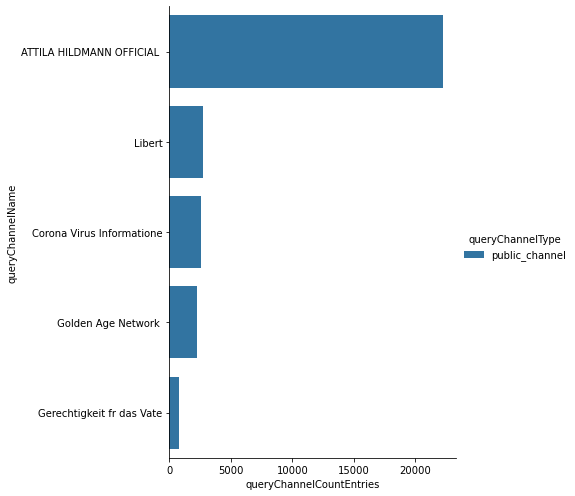

In [32]:
queryPlotter("queryChannelCountEntries")

In [33]:
#queryPlotter("queryChannelPercentRawText")

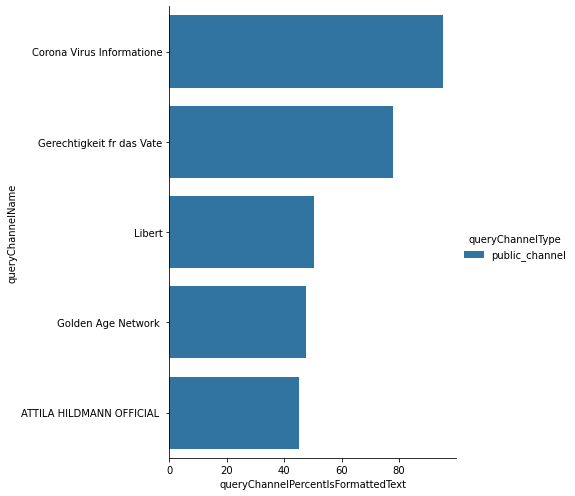

In [34]:
queryPlotter("queryChannelPercentIsFormattedText")

In [35]:
#queryPlotter("queryChannelPercentValidText") 

In [36]:
#queryPlotter("queryChannelPercentPhoto")

In [37]:
#queryPlotter("queryChannelPercentFile")

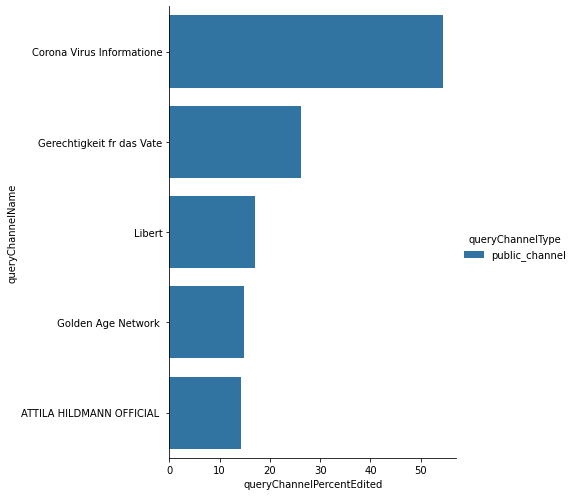

In [38]:
queryPlotter("queryChannelPercentEdited")

## Get valid text

In [39]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		30568
Before normalizedValidTextSize	19132
After normalizedValidTextSize	18769


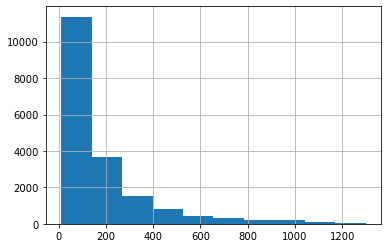

In [40]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Word Clouds

In [44]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    
    print("Top 10 occ:\n" + str(pd.Series(wordcloud.words_).head(10)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

In [45]:
#plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat")

In [46]:
#plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-janich")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
Mehr Informationen    1.000000
Menschen              0.736215
Deutschland           0.633383
Corona                0.598112
Mehr                  0.590661
mal                   0.457526
schon                 0.438649
immer                 0.415301
heute                 0.385991
gibt                  0.368604
dtype: float64
[Start generate figure]


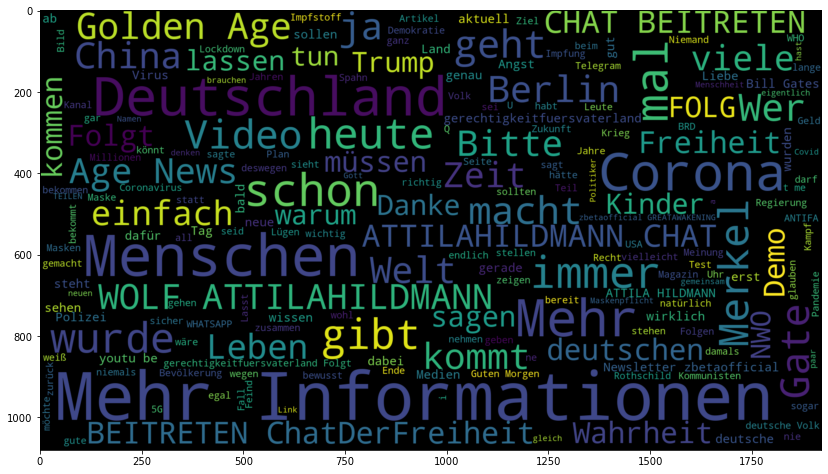

[Finished]
9.095s


In [47]:
plotChannelWordCloud("global")

In [48]:
#plotChannelWordCloud("#DS-08-10-2020/ChatExport_2020-09-27-evaherman")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
Deutschland            1.000000
Corona                 0.739456
mal                    0.610122
Gate                   0.602624
Merkel                 0.586692
schon                  0.582006
Menschen               0.567010
mehr                   0.546392
WOLF ATTILAHILDMANN    0.488285
China                  0.485473
dtype: float64
[Start generate figure]


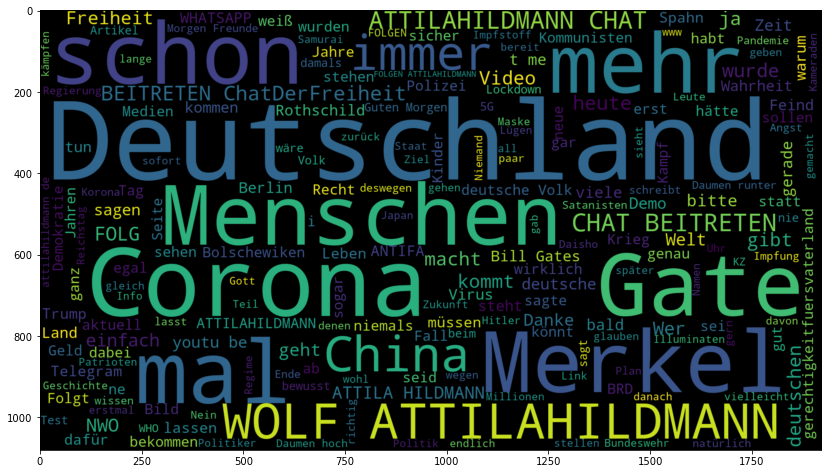

[Finished]
7.230s


In [49]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-hildmann")

In [50]:
#plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-xavier")

## Concordance

In [54]:
#t = nltk.text.Text("Hallo Welt. Was machst du gerade? Das ist nur ein Test! Schöne Welt! Das geht ja gar nicht Welt!")
#t.index("Welt")